# Pyro models about KF for COVID & Transportation

## Table of contents
(only works for local jupyter instances)

1. [Kalman Filters](#1.-Kalman-filters)  
    1.1 [Models](#1.1.-Models)  
    1.2 [Training](#1.2.-Training)  
    1.3 [Prediction](#1.3.-Prediction)
    * [One variable](#Simple-Kalman-filter-(1-variable))
    * [Multivariate](#Multi-variate-Kalman-filter-(2-variable,-2-time-observed-series))
2. [Input from transportation](#2.-Input-from-transportation)
3. [Extended Kalman Filters](#3.-Extended-filters)

In [1]:
!pip install numpyro

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import sys

from os.path import pardir, join

import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

from torch.distributions import constraints
import numpy

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

Directories relative to this repository just to have things tidy.

In [3]:
ROOT = pardir
SRC_MODELS = join(ROOT, "src", "models")
plt.rcParams['figure.figsize'] = (12, 7)

## 1. Kalman filters

### 1.1. Models
* KF with one latent variable and one observed time series (infected)
* KF with two latent variables and two observed time series (infected, deaths)

We will load the data and prepare it for forecasting.

In [ ]:
def f(carry, noise_t):
    """Propagate forward the time series."""
    beta, z_prev, tau = carry
    z_t = beta * z_prev + noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def multih_kf_old(T=None, T_forecast=15, hidden=4, obs=None):
    """Define Kalman Filter: multiple hidden variables; just one time series.

    Parameters
    ----------
    T:  int
    T_forecast: int
        Times to forecast ahead.
    hidden: int
        number of variables in the latent space
    obs: np.array
        observed variable (infected, deaths...)

    """
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    T = len(obs) if T is None else T
    beta = numpyro.sample(
        name="beta", fn=dist.Normal(loc=jnp.zeros(hidden), scale=jnp.ones(hidden))
    )
    
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(hidden)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=0.5))
    z_prev = numpyro.sample(
        name="z_1", fn=dist.Normal(loc=jnp.zeros(hidden), scale=jnp.ones(hidden))
    )
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(hidden, 10.0))
    Sigma_lower = jnp.matmul(
        jnp.diag(jnp.sqrt(tau)), L_Omega
    )  # lower cholesky factor of the covariance matrix
    noises = numpyro.sample(
        "noises",
        fn=dist.MultivariateNormal(loc=jnp.zeros(hidden), scale_tril=Sigma_lower),
        sample_shape=(T + T_forecast - 1,),
    )

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T + T_forecast - 1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    # Sample the observed y (y_obs) and missing y (y_mis)

    #c = numpyro.sample(name="cat", fn=dist.Binomial(hidden-1, jnp.repeat(0.5, T+T_forecast))).astype("int32")
    c = numpyro.sample(name="c", fn=dist.Normal(loc=jnp.array([[0.], [0.]]), scale=jnp.ones((2,1))))
    obs_mean = jnp.dot(z_collection[:T,:], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:,:], c).squeeze()

    numpyro.sample(
        name="y_obs",
        fn=dist.Normal(loc=obs_mean, scale=sigma),
        obs=obs,
    )
    numpyro.sample(
        name="y_pred", fn=dist.Normal(pred_mean, scale=sigma), obs=None
    )
    
def multih_kf(T, T_forecast=12, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    #T = len(obs) if T is None else T
    #W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(name="c", fn=dist.Normal(loc=jnp.array([[0.], [0.]]), scale=jnp.ones((2,1))))
    obs_mean = jnp.dot(z_collection[:T,:], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:,:], c).squeeze()

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [13]:
sys.path.append(SRC_MODELS)
from kf import singlevariate_kf, multivariate_kf

In [6]:
def split_forecast(data, T_forecast: int):
    """Split in train and validation in forecasting settings."""
    if len(data.shape) > 1:
        train, valid = data[:-T_forecast, :], data[-T_forecast:, :]
        
    else:
        train, valid = data[:-T_forecast], data[-T_forecast:]
    return train, valid

In [7]:
data_covid19=pd.read_csv(
    "https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv",
    parse_dates=['Date']
)
covid19_dk = data_covid19[data_covid19['Country'] == 'Denmark']
value=covid19_dk.loc[:,'Confirmed'].diff()
covid19_dk.loc[:, 'Confirmed_daily'] = value
covid19_dk=covid19_dk[covid19_dk['Confirmed_daily']>0]

/home/jorge/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jorge/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
T_forecast = 15
observed = covid19_dk.loc[:, 'Confirmed'].to_numpy()
conf_n_deaths = covid19_dk.loc[:, ["Confirmed", "Deaths"]].to_numpy()
train, valid = split_forecast(observed, T_forecast)
trainx2, validx2 = split_forecast(conf_n_deaths, T_forecast)

### 1.2. Training

There is a huge laep in fitting between using 3000 or 1000 samples, so let's make sure it converges.

In [33]:
def train_kf(model, data, T_forecast):
    """"""
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    nuts_kernel = NUTS(model=model)
    # burn-in is still too much in comparison with the samples
    mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
    # let T be guessed from the length of observed
    mcmc.run(rng_key_, T=59, T_forecast=T_forecast, obs=data)
    return mcmc

One hidden variable, one observed time series.

In [10]:
mcmc = train_kf(singlevariate_kf, train, T_forecast)

sample: 100%|██████████| 12000/12000 [00:50<00:00, 237.34it/s, 255 steps of size 1.25e-02. acc. prob=0.96] 


Two hidden variables, two time series.

In [11]:
mcmcx2 = train_kf(multivariate_kf, trainx2, T_forecast)

sample: 100%|██████████| 12000/12000 [01:16<00:00, 157.74it/s, 4 steps of size 9.74e-03. acc. prob=0.04]   


Multiple hidden variables, one time series. We need to reorganize the arguments to reutilize the training function. Let's use 4 hidden variables.

In [27]:
multisingle_kf = lambda T, T_forecast, obs: multih_kf(T=T, T_forecast=T_forecast, hidden=2, obs=obs)

In [32]:
train.shape

(59,)

In [35]:
mcmc_mul1ts = train_kf(multih_kf, train, T_forecast)

sample: 100%|██████████| 12000/12000 [01:27<00:00, 136.75it/s, 5 steps of size 3.49e-09. acc. prob=0.80]


### 1.3. Prediction

#### Simple Kalman filter (1 variable)

In [22]:
def get_samples(mcmc):
    return {k: v for k, v in mcmc.get_samples().items()}

def plot_samples(hmc_samples, nodes):
    """Get samples from the variables in `nodes`."""
    for node in nodes:
        if len(hmc_samples[node].shape)>1:
            n_vars = hmc_samples[node].shape[1]
            for i in range(n_vars):
                plt.figure(figsize=(4,3))
                sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
                plt.legend()
                plt.show()
        else:
            plt.figure(figsize=(4,3))
            sns.distplot(hmc_samples[node], label=node)
            plt.legend()
            plt.show()

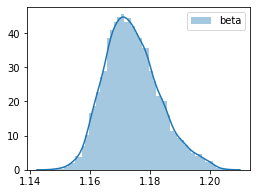

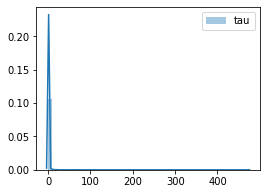

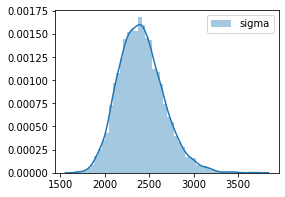

In [13]:
hmc_samples = get_samples(mcmc)
plot_samples(hmc_samples, ["beta", "tau", "sigma"])

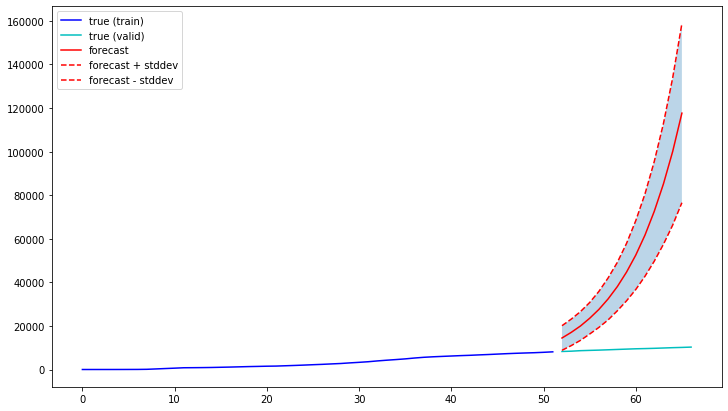

In [14]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean
T = len(train)
plt.plot(range(T), train, "b-")
plt.plot(range(T, T+T_forecast), valid, "c-")
plt.plot(range(T, T+T_forecast-1), y_pred_mean, "r-")
plt.plot(range(T, T+T_forecast-1), y_pred_025, "r--")
plt.plot(range(T, T+T_forecast-1), y_pred_975, "r--")
plt.fill_between(range(T, T+T_forecast-1), y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)", "true (valid)", "forecast","forecast + stddev","forecast - stddev"])
plt.show()

#### Multi variate Kalman filter (2 variable, 2 time observed series)

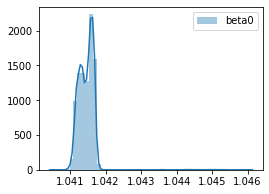

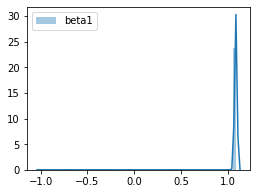

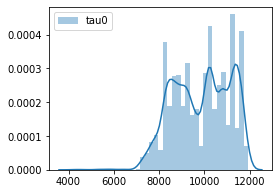

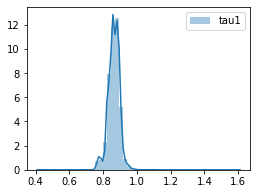

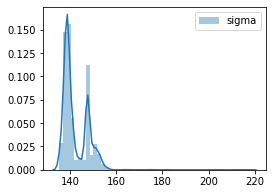

In [15]:
hmc_samplesx2 = get_samples(mcmcx2)
plot_samples(hmc_samplesx2, ["beta", "tau", "sigma"])

In [16]:
q = hmc_samplesx2["y_pred1"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean
q2 = hmc_samplesx2["y_pred2"]
q_mean2 = q2.mean(axis=0).reshape(-1,)
q_std2 = q2.std(axis=0).reshape(-1,)
y_pred_025_2 = q_mean2 - 1.96*q_std
y_pred_975_2 = q_mean2 + 1.96*q_std
y_pred_mean2 = q_mean2
T = len(trainx2)

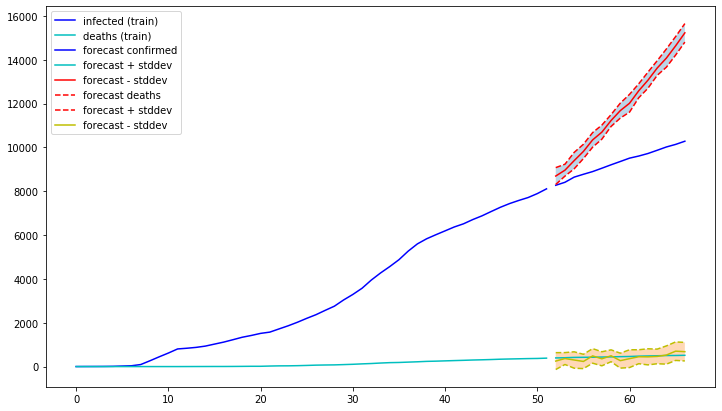

In [17]:
plt.plot(range(T), trainx2[:,0], "b-")
plt.plot(range(T), trainx2[:,1], "c-")
plt.plot(range(T, T+T_forecast), validx2[:,0], "b-")
plt.plot(range(T, T+T_forecast), validx2[:,1], "c-")
plt.plot(range(T, T+T_forecast), y_pred_mean, "r-")
plt.plot(range(T, T+T_forecast), y_pred_025, "r--")
plt.plot(range(T, T+T_forecast), y_pred_975, "r--")
plt.fill_between(range(T, T+T_forecast), y_pred_025, y_pred_975, alpha=0.3)
plt.plot(range(T, T+T_forecast), y_pred_mean2, "y-")
plt.plot(range(T, T+T_forecast), y_pred_025_2, "y--")
plt.plot(range(T, T+T_forecast), y_pred_975_2, "y--")
plt.fill_between(range(T, T+T_forecast), y_pred_025_2, y_pred_975_2, alpha=0.3)
plt.legend([
    "infected (train)","deaths (train)", "forecast confirmed", "forecast + stddev",
    "forecast - stddev","forecast deaths","forecast + stddev","forecast - stddev"
])
plt.show()

Let's see what's going on with the deaths on a proper scale.

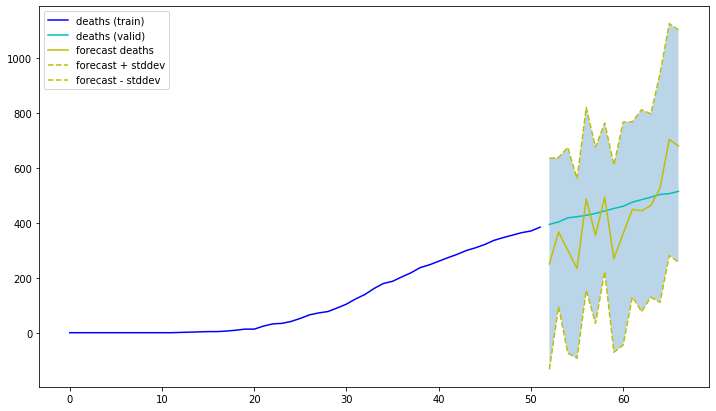

In [18]:
plt.plot(range(T), trainx2[:,1], "b-")
plt.plot(range(T, T+T_forecast), validx2[:,1], "c-")
plt.plot(range(T, T+T_forecast), y_pred_mean2, "y-")
plt.plot(range(T, T+T_forecast), y_pred_025_2, "y--")
plt.plot(range(T, T+T_forecast), y_pred_975_2, "y--")
plt.fill_between(range(T, T+T_forecast), y_pred_025_2, y_pred_975_2, alpha=0.3)
plt.legend([
    "deaths (train)", "deaths (valid)", "forecast deaths","forecast + stddev","forecast - stddev"
])
plt.show()

Not proper at all.

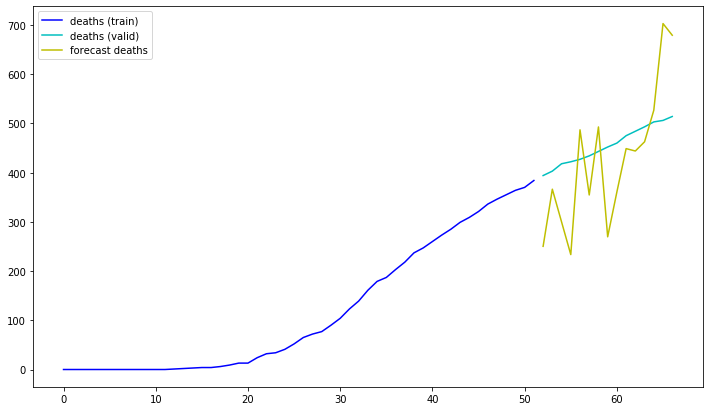

In [19]:
plt.plot(range(T), trainx2[:,1], "b-")
plt.plot(range(T, T+T_forecast), validx2[:,1], "c-")
plt.plot(range(T, T+T_forecast), y_pred_mean2, "y-")
plt.legend([
    "deaths (train)", "deaths (valid)", "forecast deaths"
])
plt.show()

Not bad.

#### Multi variate Kalman filter (4 latent variables, 1 time observed series)

LinAlgError: singular matrix

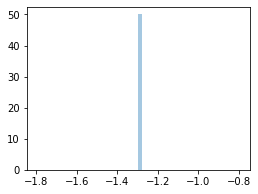

In [30]:
hmc_samplesx4 = get_samples(mcmc_mul1ts)
plot_samples(hmc_samplesx4, ["beta", "tau", "sigma"])

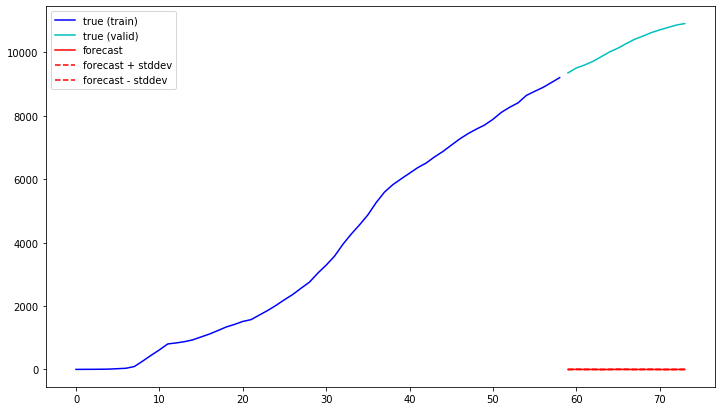

In [31]:
q = hmc_samplesx4["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean
T = len(train)
plt.plot(range(T), train, "b-")
plt.plot(range(T, T+T_forecast), valid, "c-")
plt.plot(range(T, T+T_forecast), y_pred_mean, "r-")
plt.plot(range(T, T+T_forecast), y_pred_025, "r--")
plt.plot(range(T, T+T_forecast), y_pred_975, "r--")
plt.fill_between(range(T, T+T_forecast), y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["true (train)", "true (valid)", "forecast","forecast + stddev","forecast - stddev"])
plt.show()

I don't know what to think (with more variables is even worse). Taking the mean over the hidden values and using that as mean for the emitted variable works better but I don't know about the stastistical meaning of that.

## 2. Input from transportation 

### 2.1. Models

### 2.2. Training

### 2.3. Prediction

## 3. Extended filters

### 3.1. Models

### 3.2. Training

### 3.3. Prediction